In [1]:
# change this to the right path if you use a different path
# or specify the ORCA_PATH environmental variable
import os
import sys
if os.getenv("ORCA_PATH"):
    ORCA_PATH = os.getenv("ORCA_PATH")
else:
    ORCA_PATH = "../orca"
sys.path.append(ORCA_PATH)

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
import orca_predict 
orca_predict.load_resources(models=['1M','32M'],use_cuda=True)
from orca_predict import *

In <PYTHONPATH>/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In <PYTHONPATH>/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In <PYTHONPATH>/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [4]:

def predict(chrm, pos,plotfile=None):
    with torch.no_grad():
        chrlen = [l for c, l in hg38.get_chr_lens() if c == chrm].pop()
        wpos = coord_clip(pos, chrlen)
        
        sequence = hg38.get_encoding_from_coords(chrm, wpos-16000000, wpos+16000000 )[None,:,:]
        outputs = genomepredict(sequence, chrm, mpos=pos, wpos=wpos , \
                                    targets = [torch.FloatTensor(target_h1esc.get_feature_data(chrm, wpos-16000000, wpos+16000000)[None,:,:]),\
                                              torch.FloatTensor(target_hff.get_feature_data(chrm, wpos-16000000, wpos+16000000)[None,:,:])], use_cuda=False)
        p_h1esc = outputs['predictions'][0][5]
        p_hff = outputs['predictions'][1][5]
        t_h1esc  = outputs['experiments'][0][5]
        t_hff = outputs['experiments'][1][5]
        if plotfile is not None:
            genomeplot(outputs,show_genes=True, file=file)
        return p_h1esc, t_h1esc, p_hff, t_hff

In [5]:
import pandas as pd
import numpy as np
#predictions made based on https://github.com/calico/basenji/blob/master/manuscripts/akita/explore_model.ipynb
#filtered to common test sets
testset = pd.read_csv('./resources/akita_testset.csv')
pakita = np.load('./resources/akita_testset.akitapred.npy')
takita = np.load('./resources/akita_testset.target.npy')

In [6]:
#load chromatin tracks data
import torch
import pyBigWig

bwlist = [ORCA_PATH+'/extra/H1_CTCF_ENCFF473IZV.bigWig', 
          ORCA_PATH+'/extra/H1_H3K4me3_ENCFF623ZAW.bigWig',
          ORCA_PATH+'/extra/H1_H3K27ac_ENCFF423TVA.bigWig',
          ORCA_PATH+'/extra/H1_H3K4me1_ENCFF584AVI.bigWig',
          ORCA_PATH+'/extra/H1_H3K27me3_ENCFF912ZUR.bigWig',
          ORCA_PATH+'/extra/foreskin_fibroblast_CTCF_ENCFF761RHS.bigWig',
          ORCA_PATH+'/extra/foreskin_fibroblast_H3K4me3_ENCFF442WNT.bigWig',
          ORCA_PATH+'/extra/foreskin_fibroblast_H3K27ac_ENCFF078JZB.bigWig',
          ORCA_PATH+'/extra/foreskin_fibroblast_H3K4me1_ENCFF449DEA.bigWig',
          ORCA_PATH+'/extra/foreskin_fibroblast_H3K27me3_ENCFF027GWJ.bigWig']

with torch.no_grad():
    mallbws = []
    for i in range(testset.shape[0]): 
        chrm = testset['chr'][i]
        pos = int( (testset['start'][i]+testset['stop'][i])/2)
        bws = []
        for f in bwlist:
            bw = pyBigWig.open(f)
            b= np.array(bw.stats(chrm, pos-224*2048, pos+224*2048, nBins=448, type="mean", exact=True))
            bws.append([b])
        mallbws.append(bws)



In [7]:
#1Mb model trained without auxiliary task performance

import numpy as np
import torch
from torch import nn
from orca_modules import Encoder2, Encoder, Decoder, Decoder_1m, Net


class H1esc_1M_no1d(nn.Module):
    def __init__(
        self,
    ):
        super(H1esc_1M_no1d, self).__init__()
        self.net = nn.DataParallel(Net())
        num_threads = torch.get_num_threads()
        net_dict = self.net.state_dict()
        pretrained_dict = torch.load(
            "./models_extra/orca_h1esc.net0_no1d.statedict",
            map_location=torch.device("cpu"),
        )
        pretrained_dict_filtered = {
            key: pretrained_dict[ key] for key in net_dict
        }
        self.net.load_state_dict(pretrained_dict_filtered)
        self.net.eval()

        expected_log = np.load(
            ORCA_PATH + "/resources/4DNFI9GMP2J8.rebinned.mcool.expected.res1000.npy"
        )[:1000]

        normmat = np.exp(
            expected_log[np.abs(np.arange(1000)[None, :] - np.arange(1000)[:, None])]
        )

        normmat_r = np.reshape(normmat, (250, 4, 250, 4)).mean(axis=1).mean(axis=2)
        eps = np.min(normmat_r)

        self.normmats = {1: normmat_r}
        self.epss = {1: eps}
        self.distenc = torch.log(torch.FloatTensor(self.normmats[1][None, None, :, :]))
        torch.set_num_threads(num_threads)

    def forward(self, x):
        pred, _ = self.net.forward(
            x.transpose(1, 2), self.distenc.expand(x.shape[0], 1, 250, 250)
        )

        return pred


class Hff_1M_no1d(nn.Module):
    def __init__(
        self,
    ):
        super(Hff_1M_no1d, self).__init__()
        self.net = nn.DataParallel(Net())
        num_threads = torch.get_num_threads()
        net_dict = self.net.state_dict()
        pretrained_dict = torch.load(
            "./models_extra/orca_hff.net0_no1d.statedict",
            map_location=torch.device("cpu"),
        )
        pretrained_dict_filtered = {
            key: pretrained_dict[key] for key in net_dict
        }
        self.net.load_state_dict(pretrained_dict_filtered)
        self.net.eval()

        expected = np.exp(
            np.load(ORCA_PATH + "/resources/4DNFI643OYP9.rebinned.mcool.expected.res1000.npy")[
                :1000
            ]
        )
        normmat = expected[np.abs(np.arange(1000)[:, None] - np.arange(1000)[None, :])]

        normmat_r = np.reshape(normmat, (250, 4, 250, 4)).mean(axis=1).mean(axis=2)
        eps = np.min(normmat_r)

        self.normmats = {1: normmat_r}
        self.epss = {1: eps}
        torch.set_num_threads(num_threads)

    def forward(self, x):
        pred, _ = self.net.forward(x.transpose(1, 2))
        return pred

    
h1esc_1m_no1d = H1esc_1M_no1d()
hff_1m_no1d = Hff_1M_no1d()
h1esc_1m_no1d.eval()
hff_1m_no1d.eval()
h1esc_1m_no1d.cuda()
hff_1m_no1d.cuda()

def predict_no1d(chrm, pos):    
    with torch.no_grad():
        sequence = hg38.get_encoding_from_coords(chrm, pos-500000, pos+500000)
        seqs = [torch.FloatTensor(sequence[None,:,:]), torch.FloatTensor(sequence[None,::-1,::-1].copy())]

        pred_h1esc = 0.5*h1esc_1m_no1d.net(seqs[0].transpose(1,2)).cpu().detach().numpy()[:,0,:,:]+0.5*h1esc_1m_no1d.net(seqs[1].transpose(1,2)).cpu().detach().numpy()[:,0,::-1,::-1]
        pred_hff = 0.5*hff_1m_no1d.net(seqs[0].transpose(1,2)).cpu().detach().numpy()[:,0,:,:]+0.5*hff_1m_no1d.net(seqs[1].transpose(1,2)).cpu().detach().numpy()[:,0,::-1,::-1]

        return pred_h1esc[0], pred_hff[0]
    
    
def predict_1m(chrm, pos):    
    with torch.no_grad():
        sequence = hg38.get_encoding_from_coords(chrm, pos-500000, pos+500000)
        seqs = [torch.FloatTensor(sequence[None,:,:]), torch.FloatTensor(sequence[None,::-1,::-1].copy())]

        pred_h1esc = 0.5*h1esc_1m.forward(seqs[0].transpose(1,2)).cpu().detach().numpy()[:,0,:,:]+0.5*h1esc_1m.forward(seqs[1].transpose(1,2)).cpu().detach().numpy()[:,0,::-1,::-1]
        pred_hff = 0.5*hff_1m.forward(seqs[0].transpose(1,2)).cpu().detach().numpy()[:,0,:,:]+0.5*hff_1m.forward(seqs[1].transpose(1,2)).cpu().detach().numpy()[:,0,::-1,::-1]

        return pred_h1esc[0], pred_hff[0]


In [8]:
ps_h1esc = []
ps_hff = []
ts_h1esc = []
ts_hff = []

for i in range(testset.shape[0]): 
    p_h1esc, t_h1esc, p_hff, t_hff = predict(testset['chr'][i], int( (testset['start'][i]+testset['stop'][i])/2))
    ps_h1esc.append(p_h1esc)
    ps_hff.append(p_hff)
    ts_h1esc.append(t_h1esc)
    ts_hff.append(t_hff)
    

<PYTHONPATH>/lib/python3.7/site-packages/cooltools/lib/numutils.py:1317: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur
<PYTHONPATH>/lib/python3.7/site-packages/cooltools/lib/numutils.py:1317: RuntimeWarning: divide by zero encountered in true_divide
  val_cur = ar_cur / armask_cur
../orca/orca_predict.py:396: RuntimeWarning: Mean of empty slice
  axis=4,
../orca/orca_predict.py:398: RuntimeWarning: Mean of empty slice
  axis=2,
<PYTHONPATH>/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [9]:
ps_h1esc_no1d = []
ps_hff_no1d = []
for i in range(testset.shape[0]): 
    p_h1esc, p_hff = predict_no1d(testset['chr'][i], int( (testset['start'][i]+testset['stop'][i])/2))
    ps_h1esc_no1d.append(p_h1esc)
    ps_hff_no1d.append(p_hff)

<PYTHONPATH>/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


In [10]:
ps_h1esc_1m = []
ps_hff_1m = []
for i in range(testset.shape[0]): 
    p_h1esc, p_hff = predict_1m(testset['chr'][i], int( (testset['start'][i]+testset['stop'][i])/2))
    ps_h1esc_1m.append(p_h1esc)
    ps_hff_1m.append(p_hff)

In [11]:
smooth_diag = np.load(ORCA_PATH+"/resources/4DNFI9GMP2J8.rebinned.mcool.expected.res4000.npy")
normmat_h1esc = np.exp(smooth_diag[np.abs(np.arange(250)[:, None] - np.arange(250)[None, :])])

smooth_diag = np.load(ORCA_PATH+"/resources/4DNFI643OYP9.rebinned.mcool.expected.res4000.npy")
normmat_hff = np.exp(smooth_diag[np.abs(np.arange(250)[:, None] - np.arange(250)[None, :])])


In [12]:
def scale_hff(x):
    return np.log((np.exp(x)*(normmat_hff + np.min(normmat_hff))-np.min(normmat_hff))/normmat_hff)

def scale_h1esc(x):
    return np.log((np.exp(x)*(normmat_h1esc + np.min(normmat_h1esc))-np.min(normmat_h1esc))/normmat_h1esc)

In [13]:
from torch import nn
from scipy.ndimage import gaussian_filter

akita_crop_factor = 448 * 2000 / 1000000
crop_length  = int((500 - akita_crop_factor * 500)/2)

#resize to (500, 500) and crop to akita format
#Akita applied gaussian smoothing and clipping to -2,2 while Orca does not 
#here we compared with Akita after applying Gaussian filtering and clipping.
def to_akita_format(x, gaussian_smoothr=True, clip=True):
    upscaled_x = nn.Upsample(size = [500 ,500], mode='bilinear')(torch.Tensor(x[None,None,:,:])).numpy().squeeze()
    if gaussian_smoothr:
        upscaled_x = gaussian_filter(upscaled_x,1,truncate=2)
    if clip:
        upscaled_x = np.clip(upscaled_x, -2, 2)
    return upscaled_x[crop_length:-crop_length, crop_length:-crop_length]

In [14]:
def diagmean(mat):
    means = []
    for i in range(0, mat.shape[0]):
        means.append(np.nanmean(np.diag(mat, k=i)))
    return np.array(means)
    
def diagmeanmat(mat):
    means = diagmean(mat)
    return means[np.abs((np.arange(mat.shape[0])[None,:]-np.arange(mat.shape[0])[:,None]))]

def rm_diagmean(mat):
    return mat - diagmeanmat(mat)

<PYTHONPATH>/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


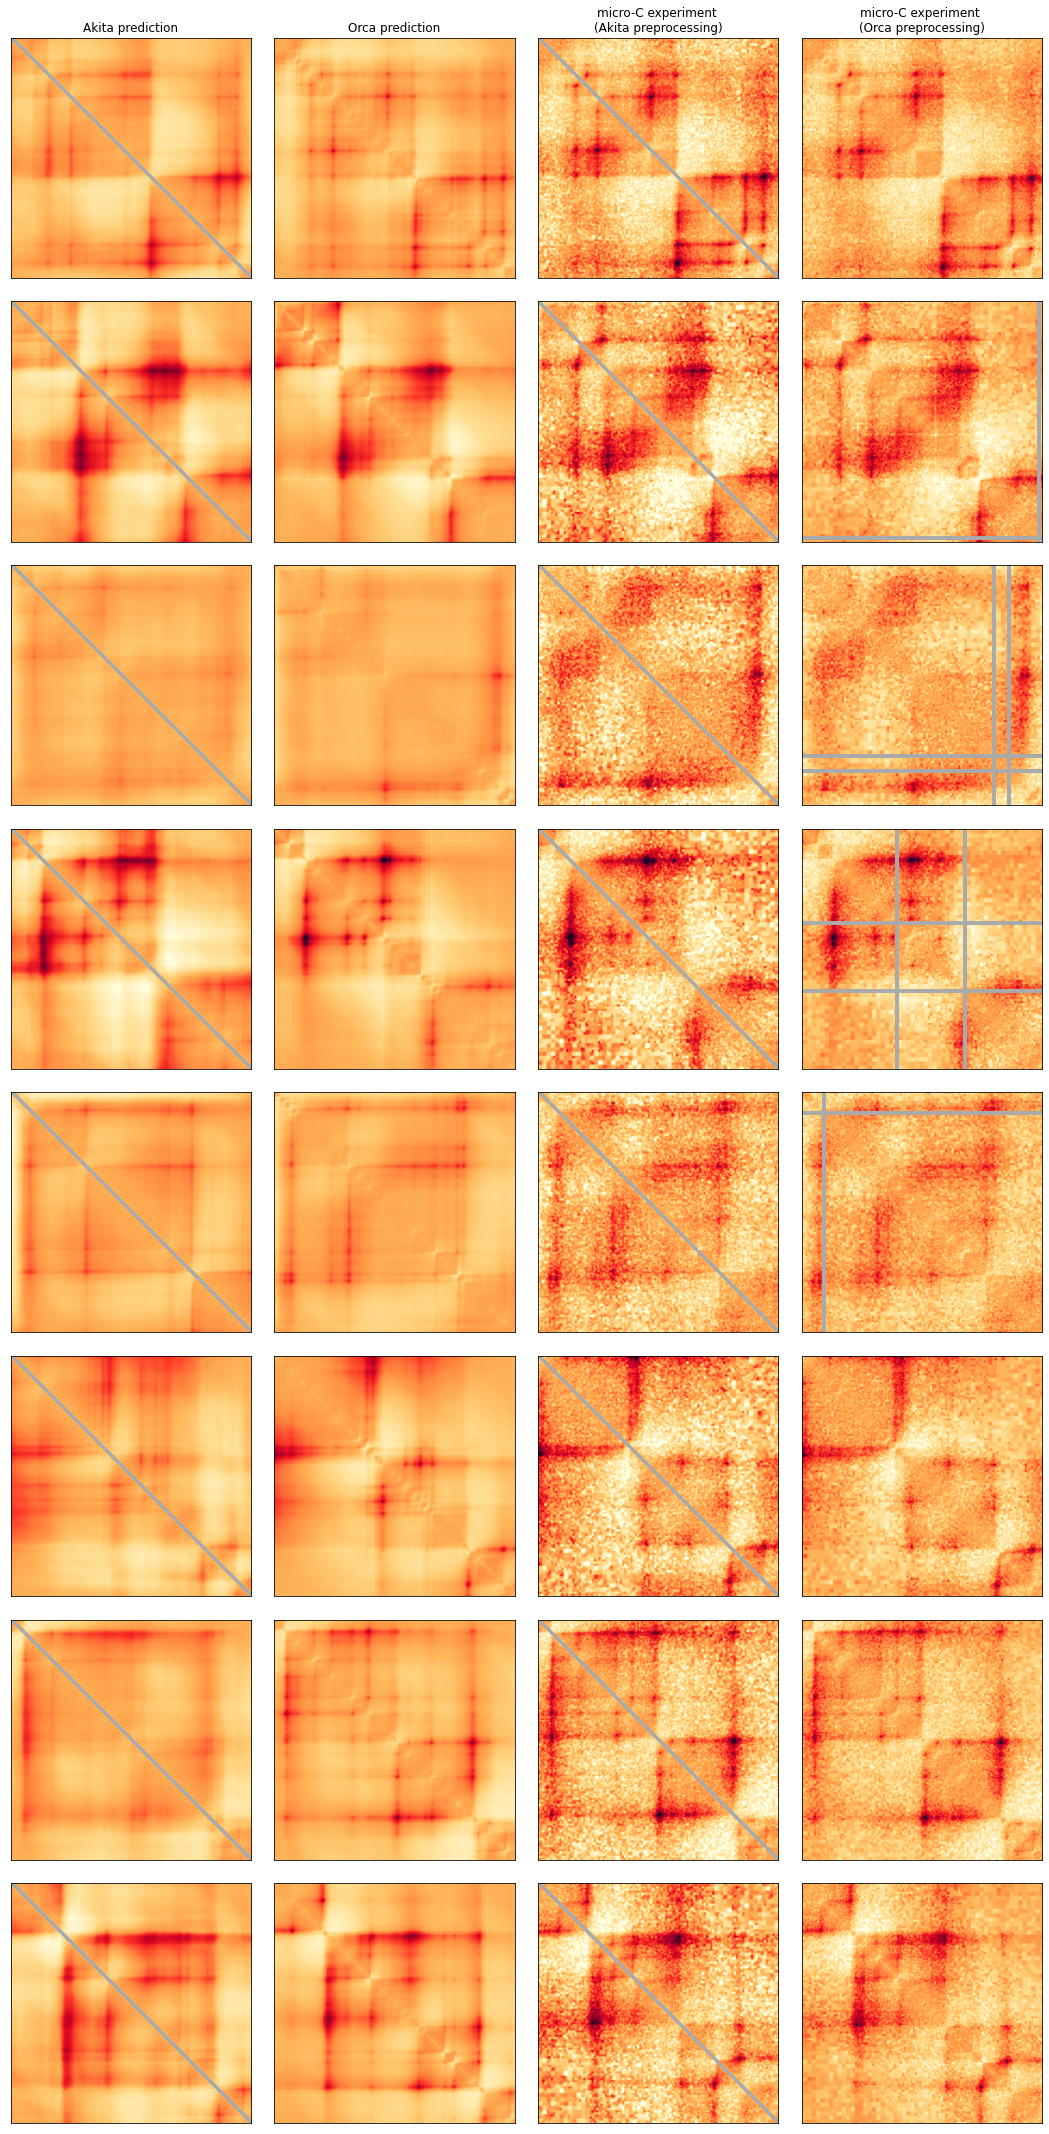

In [15]:
from matplotlib import pyplot as plt
from colormaps import hnh_cmap_ext5
fig, axes  = plt.subplots(nrows=8, ncols=4, figsize=(15,30))
np.random.seed(1)

inds = np.random.permutation(np.arange(41))
for i, ax in enumerate(axes):
    ax[0].imshow(rm_diagmean(pakita[0,inds[i],:,:]), vmin=-1, vmax=2, cmap=hnh_cmap_ext5)
    ax[1].imshow(rm_diagmean(to_akita_format(ps_h1esc[inds[i]], gaussian_smoothr=False)), vmin=-1, vmax=2, cmap=hnh_cmap_ext5)
    ax[2].imshow(rm_diagmean(takita[0,inds[i],:,:]), vmin=-1, vmax=2, cmap=hnh_cmap_ext5)
    ax[3].imshow(rm_diagmean(to_akita_format(ts_h1esc[inds[i]], gaussian_smoothr=False)), vmin=-1, vmax=2, cmap=hnh_cmap_ext5)
    for a in ax:
        a.get_xaxis().set_ticks([])
        a.get_yaxis().set_ticks([])
    if i == 0:
        ax[0].set_title("Akita prediction")
        ax[1].set_title("Orca prediction")
        ax[2].set_title("micro-C experiment \n(Akita preprocessing)")
        ax[3].set_title("micro-C experiment \n(Orca preprocessing)")

plt.tight_layout(pad=2)
fig.show()
plt.savefig('./figures/akitacomparison.pdf')

In [16]:
%load_ext rpy2.ipython

In [17]:
#orca target - distance normalized


from scipy.stats import spearmanr, pearsonr
akita_cors  = []
orca_cors = []
orca_1m_cors = []
orca_no1d_cors = []
for i in range(pakita.shape[1]):

    #because distance-based expectation normalization is implementedly slightly differently between the Akita and Orca
    #to allow comparison, we averaged the targets between the two 
    target = to_akita_format(ts_h1esc[i])
    valid = (~np.isnan(pakita[0,i,:,:].flatten())) & (~np.isnan(target.flatten()))
    

    akita_cors.append(pearsonr(rm_diagmean(pakita[0,i,:,:]).flatten()[valid], rm_diagmean(target).flatten()[valid])[0])
    orca_cors.append(pearsonr(rm_diagmean(to_akita_format(ps_h1esc[i])).flatten()[valid], rm_diagmean(target).flatten()[valid])[0])
    orca_1m_cors.append(pearsonr(rm_diagmean(to_akita_format(ps_h1esc_1m[i])).flatten()[valid], rm_diagmean(target).flatten()[valid])[0])
    orca_no1d_cors.append(pearsonr(rm_diagmean(to_akita_format(ps_h1esc_no1d[i])).flatten()[valid], rm_diagmean(target).flatten()[valid])[0])

plotdata = pd.DataFrame(dict(akita=akita_cors,
                             orca=orca_cors, 
                             orca_1m=orca_1m_cors, 
                             orca_no1d=orca_no1d_cors, 
                             celltype='H1-ESC'))
akita_cors  = []
orca_cors = []
orca_1m_cors = []
orca_no1d_cors = []
for i in range(pakita.shape[1]):
    target =  to_akita_format(ts_hff[i])
    valid = (~np.isnan(pakita[1,i,:,:].flatten())) & (~np.isnan(target.flatten()))
    
    akita_cors.append(pearsonr(rm_diagmean(pakita[1,i,:,:]).flatten()[valid], rm_diagmean(target).flatten()[valid])[0])
    orca_cors.append(pearsonr(rm_diagmean(to_akita_format(ps_hff[i])).flatten()[valid], rm_diagmean(target).flatten()[valid])[0])
    orca_1m_cors.append(pearsonr(rm_diagmean(to_akita_format(ps_hff_1m[i])).flatten()[valid], rm_diagmean(target).flatten()[valid])[0])
    orca_no1d_cors.append(pearsonr(rm_diagmean(to_akita_format(ps_hff_no1d[i])).flatten()[valid], rm_diagmean(target).flatten()[valid])[0])

plotdata = pd.concat([plotdata, pd.DataFrame(dict(akita=akita_cors,
                             orca=orca_cors, 
                             orca_1m=orca_1m_cors, 
                             orca_no1d=orca_no1d_cors, 
                             celltype='HFF'))], axis=0)

akita_cors  = []
orca_cors = []
orca_1m_cors = []
orca_no1d_cors = []
for i in range(pakita.shape[1]):
    target = to_akita_format(ts_h1esc[i]) * 0.5 - to_akita_format(ts_hff[i]) * 0.5 
    valid = (~np.isnan(pakita[0,i,:,:].flatten())) & (~np.isnan(target.flatten()))
    

    akita_cors.append(pearsonr(rm_diagmean(pakita[0,i,:,:]).flatten()[valid]-rm_diagmean(pakita[1,i,:,:]).flatten()[valid], rm_diagmean(target).flatten()[valid])[0])
    orca_cors.append(pearsonr(rm_diagmean(to_akita_format(ps_h1esc[i])).flatten()[valid]-rm_diagmean(to_akita_format(ps_hff[i])).flatten()[valid], rm_diagmean(target).flatten()[valid])[0])
    orca_1m_cors.append(pearsonr(rm_diagmean(to_akita_format(ps_h1esc_1m[i])).flatten()[valid]-rm_diagmean(to_akita_format(ps_hff[i])).flatten()[valid], rm_diagmean(target).flatten()[valid])[0])
    orca_no1d_cors.append(pearsonr(rm_diagmean(to_akita_format(ps_h1esc_no1d[i])).flatten()[valid]-rm_diagmean(to_akita_format(ps_hff[i])).flatten()[valid], rm_diagmean(target).flatten()[valid])[0])

plotdata = pd.concat([plotdata, pd.DataFrame(dict(akita=akita_cors,
                             orca=orca_cors, 
                             orca_1m=orca_1m_cors, 
                             orca_no1d=orca_no1d_cors, 
                             celltype='Difference (H1-ESC - HFF)'))], axis=0)

<PYTHONPATH>/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.





  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang



                    celltype akita_correlation
1:                    H1-ESC         0.6205960
2:                       HFF         0.4864833
3: Difference (H1-ESC - HFF)         0.1326892
                    celltype orca_correlation
1:                    H1-ESC        0.7709512
2:                       HFF        0.6095295
3: Difference (H1-ESC - HFF)        0.3486793


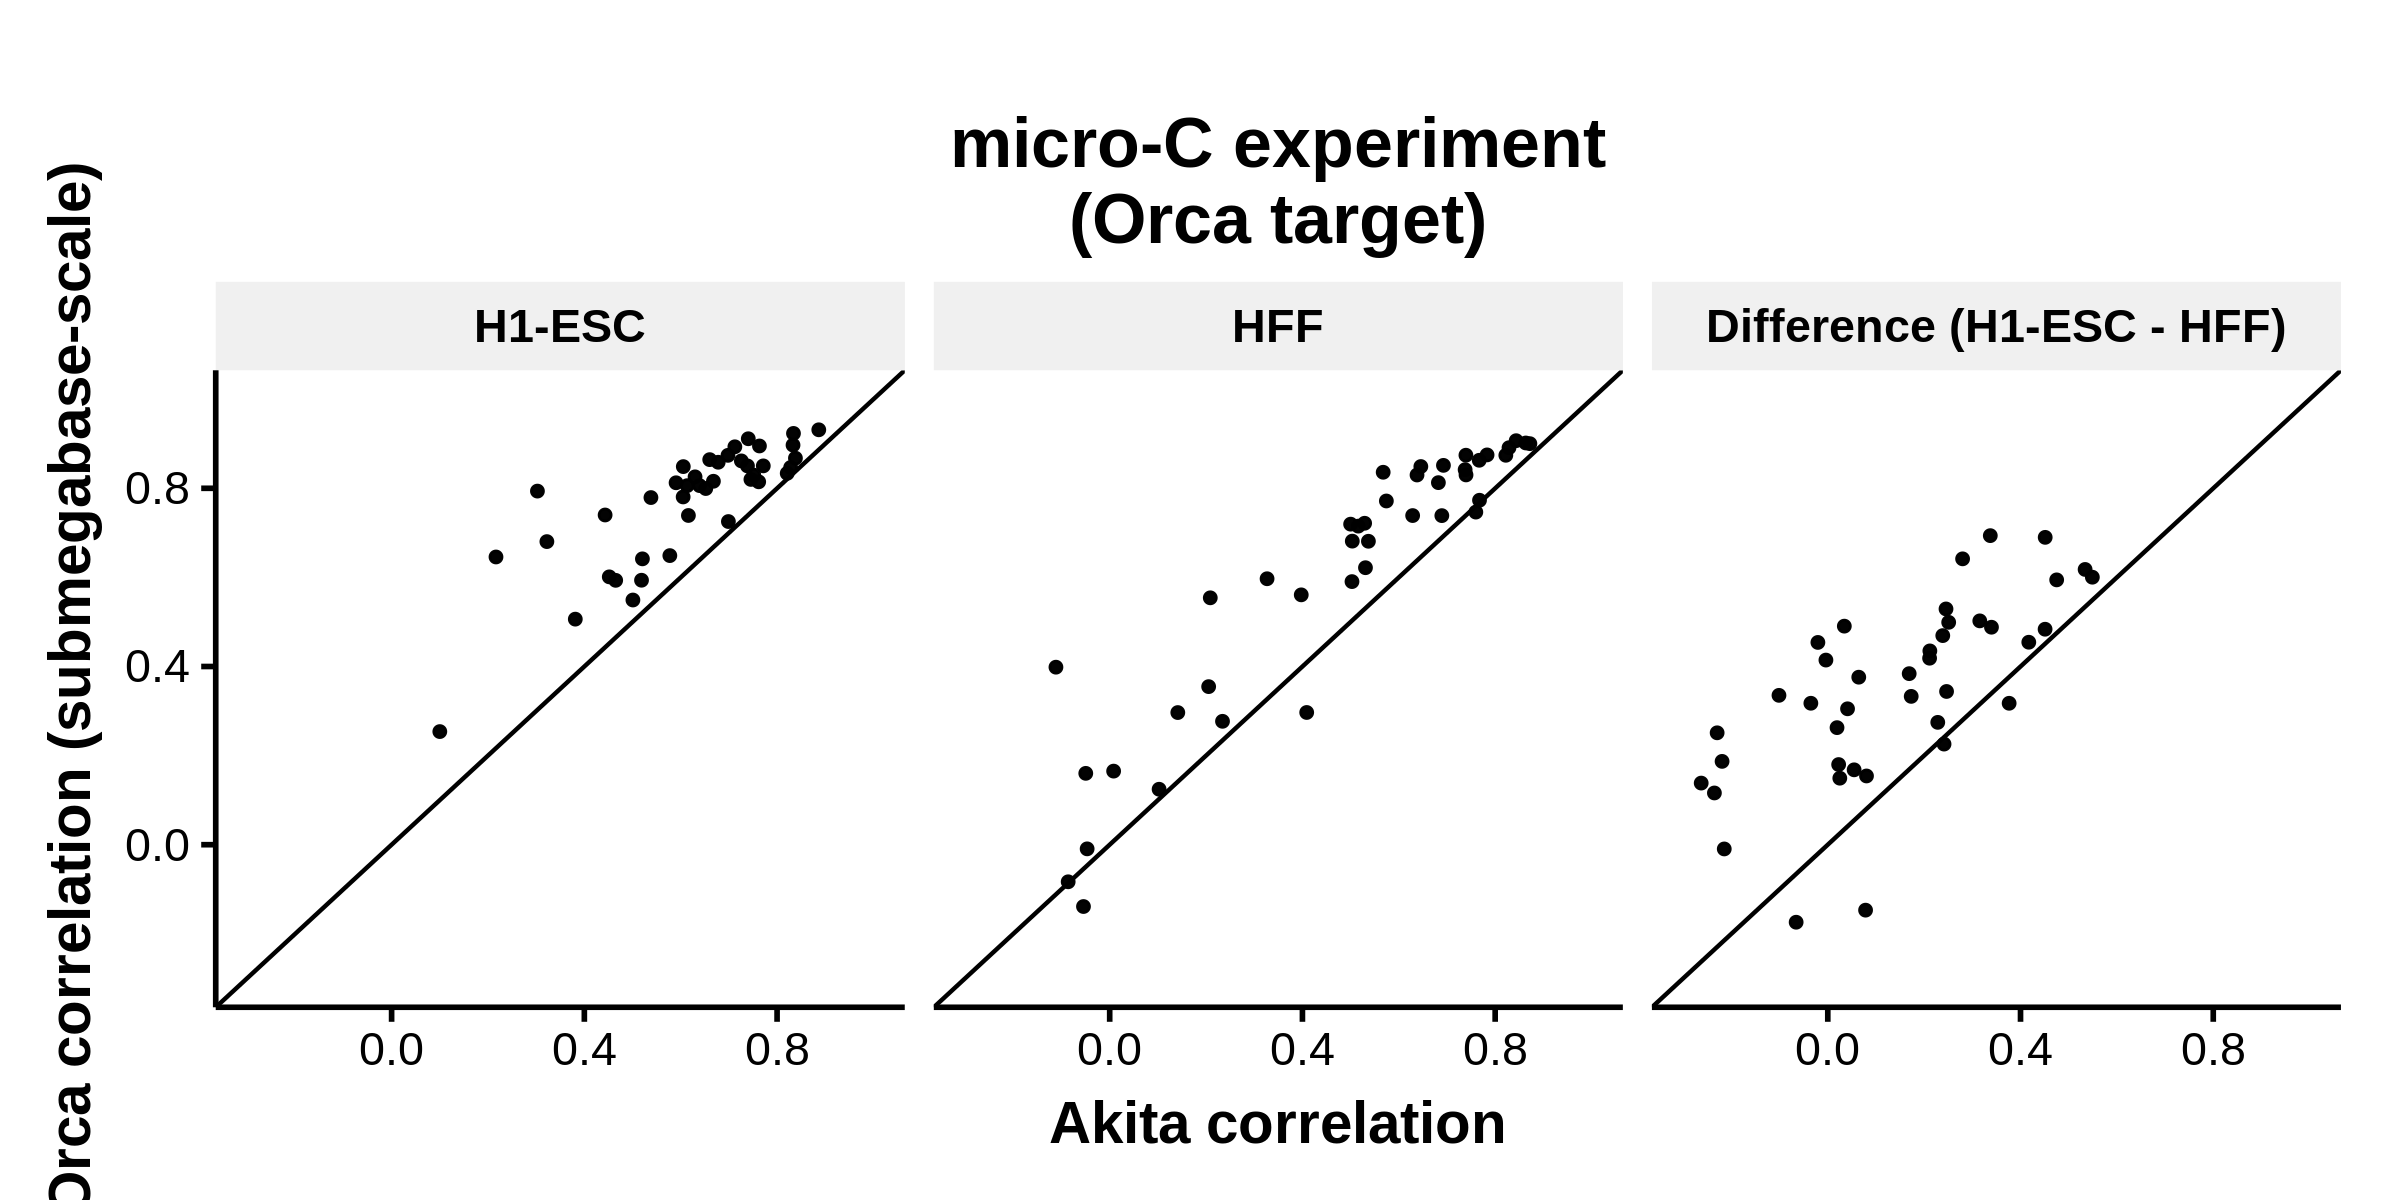

In [18]:
%%R -i plotdata -w 8 -h 4 --units in -r 300

require(data.table)
require(ggplot2)
theme_Publication <- function(base_size=14, base_family="helvetica") {
      library(grid)
      library(ggthemes)
      (theme_foundation(base_size=base_size, base_family=base_family)
       + theme(plot.title = element_text(face = "bold",
                                         size = rel(1.2), hjust = 0.5),
               text = element_text(),
               panel.background = element_rect(colour = NA),
               plot.background = element_rect(colour = NA),
               panel.border = element_rect(colour = NA),
               axis.title = element_text(face = "bold",size = rel(1)),
               axis.title.y = element_text(angle=90,vjust =2),
               axis.title.x = element_text(vjust = -0.2),
               axis.text = element_text(), 
               axis.line = element_line(colour="black"),
               axis.ticks = element_line(),
               panel.grid.major = element_blank(),
               panel.grid.minor = element_blank(),
               legend.key = element_rect(colour = NA),
               legend.position = "bottom",
               legend.direction = "horizontal",
               legend.key.size= unit(0.2, "cm"),
               legend.margin = unit(0, "cm"),
               legend.title = element_text(face="italic"),
               plot.margin=unit(c(10,5,5,5),"mm"),
               strip.background=element_rect(colour="#f0f0f0",fill="#f0f0f0"),
               strip.text = element_text(face="bold")
          ))
      
}

plotdata = data.table(plotdata)
print(plotdata[, .(akita_correlation=mean(akita)), by=celltype])
print(plotdata[, .(orca_correlation=mean(orca)), by=celltype])
plotdata$celltype = factor(plotdata$celltype, levels=c('H1-ESC','HFF','Difference (H1-ESC - HFF)'))
p= ggplot(plotdata)+geom_abline(slope=1)+geom_point(aes(y=orca, x=akita),size=I(1),alpha=I(0.99)) + facet_wrap(~celltype) + theme_minimal()+
scale_x_continuous(lim=c(-0.3,1))+scale_y_continuous(lim=c(-0.3,1))+xlab("Akita correlation")+
    ylab("Orca correlation (submegabase-scale)")+theme_Publication ()+labs(title = "micro-C experiment\n(Orca target)")

p
ggsave('./figures/akitacomparison.cor.orcatarget.pdf', device=cairo_pdf)
p

In [19]:
#akita target - distance normalized


from scipy.stats import spearmanr, pearsonr
akita_cors  = []
orca_cors = []
orca_1m_cors = []
orca_no1d_cors = []
for i in range(pakita.shape[1]):

    #because distance-based expectation normalization is implementedly slightly differently between the Akita and Orca
    #to allow comparison, we averaged the targets between the two 
    target = takita[0,i,:,:]
    valid = (~np.isnan(pakita[0,i,:,:].flatten())) & (~np.isnan(target.flatten()))
    

    akita_cors.append(pearsonr(rm_diagmean(pakita[0,i,:,:]).flatten()[valid], rm_diagmean(target).flatten()[valid])[0])
    orca_cors.append(pearsonr(rm_diagmean(to_akita_format(ps_h1esc[i])).flatten()[valid], rm_diagmean(target).flatten()[valid])[0])
    orca_1m_cors.append(pearsonr(rm_diagmean(to_akita_format(ps_h1esc_1m[i])).flatten()[valid], rm_diagmean(target).flatten()[valid])[0])
    orca_no1d_cors.append(pearsonr(rm_diagmean(to_akita_format(ps_h1esc_no1d[i])).flatten()[valid], rm_diagmean(target).flatten()[valid])[0])

plotdata = pd.DataFrame(dict(akita=akita_cors,
                             orca=orca_cors, 
                             orca_1m=orca_1m_cors, 
                             orca_no1d=orca_no1d_cors, 
                             celltype='H1-ESC'))
akita_cors  = []
orca_cors = []
orca_1m_cors = []
orca_no1d_cors = []
for i in range(pakita.shape[1]):
    target = takita[1,i,:,:] 
    valid = (~np.isnan(pakita[1,i,:,:].flatten())) & (~np.isnan(target.flatten()))
    
    akita_cors.append(pearsonr(rm_diagmean(pakita[1,i,:,:]).flatten()[valid], rm_diagmean(target).flatten()[valid])[0])
    orca_cors.append(pearsonr(rm_diagmean(to_akita_format(ps_hff[i])).flatten()[valid], rm_diagmean(target).flatten()[valid])[0])
    orca_1m_cors.append(pearsonr(rm_diagmean(to_akita_format(ps_hff_1m[i])).flatten()[valid], rm_diagmean(target).flatten()[valid])[0])
    orca_no1d_cors.append(pearsonr(rm_diagmean(to_akita_format(ps_hff_no1d[i])).flatten()[valid], rm_diagmean(target).flatten()[valid])[0])

plotdata = pd.concat([plotdata, pd.DataFrame(dict(akita=akita_cors,
                             orca=orca_cors, 
                             orca_1m=orca_1m_cors, 
                             orca_no1d=orca_no1d_cors, 
                             celltype='HFF'))], axis=0)

akita_cors  = []
orca_cors = []
orca_1m_cors = []
orca_no1d_cors = []
for i in range(pakita.shape[1]):
    target = takita[0,i,:,:] * 0.5 - takita[1,i,:,:] * 0.5
    valid = (~np.isnan(pakita[0,i,:,:].flatten())) & (~np.isnan(target.flatten()))
    

    akita_cors.append(pearsonr(rm_diagmean(pakita[0,i,:,:]).flatten()[valid]-rm_diagmean(pakita[1,i,:,:]).flatten()[valid], rm_diagmean(target).flatten()[valid])[0])
    orca_cors.append(pearsonr(rm_diagmean(to_akita_format(ps_h1esc[i])).flatten()[valid]-rm_diagmean(to_akita_format(ps_hff[i])).flatten()[valid], rm_diagmean(target).flatten()[valid])[0])
    orca_1m_cors.append(pearsonr(rm_diagmean(to_akita_format(ps_h1esc_1m[i])).flatten()[valid]-rm_diagmean(to_akita_format(ps_hff[i])).flatten()[valid], rm_diagmean(target).flatten()[valid])[0])
    orca_no1d_cors.append(pearsonr(rm_diagmean(to_akita_format(ps_h1esc_no1d[i])).flatten()[valid]-rm_diagmean(to_akita_format(ps_hff[i])).flatten()[valid], rm_diagmean(target).flatten()[valid])[0])

plotdata = pd.concat([plotdata, pd.DataFrame(dict(akita=akita_cors,
                             orca=orca_cors, 
                             orca_1m=orca_1m_cors, 
                             orca_no1d=orca_no1d_cors, 
                             celltype='Difference (H1-ESC - HFF)'))], axis=0)

<PYTHONPATH>/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


                    celltype akita_correlation
1:                    H1-ESC         0.5954877
2:                       HFF         0.4725998
3: Difference (H1-ESC - HFF)         0.1152925
                    celltype orca_correlation
1:                    H1-ESC        0.6652800
2:                       HFF        0.5365243
3: Difference (H1-ESC - HFF)        0.2549193


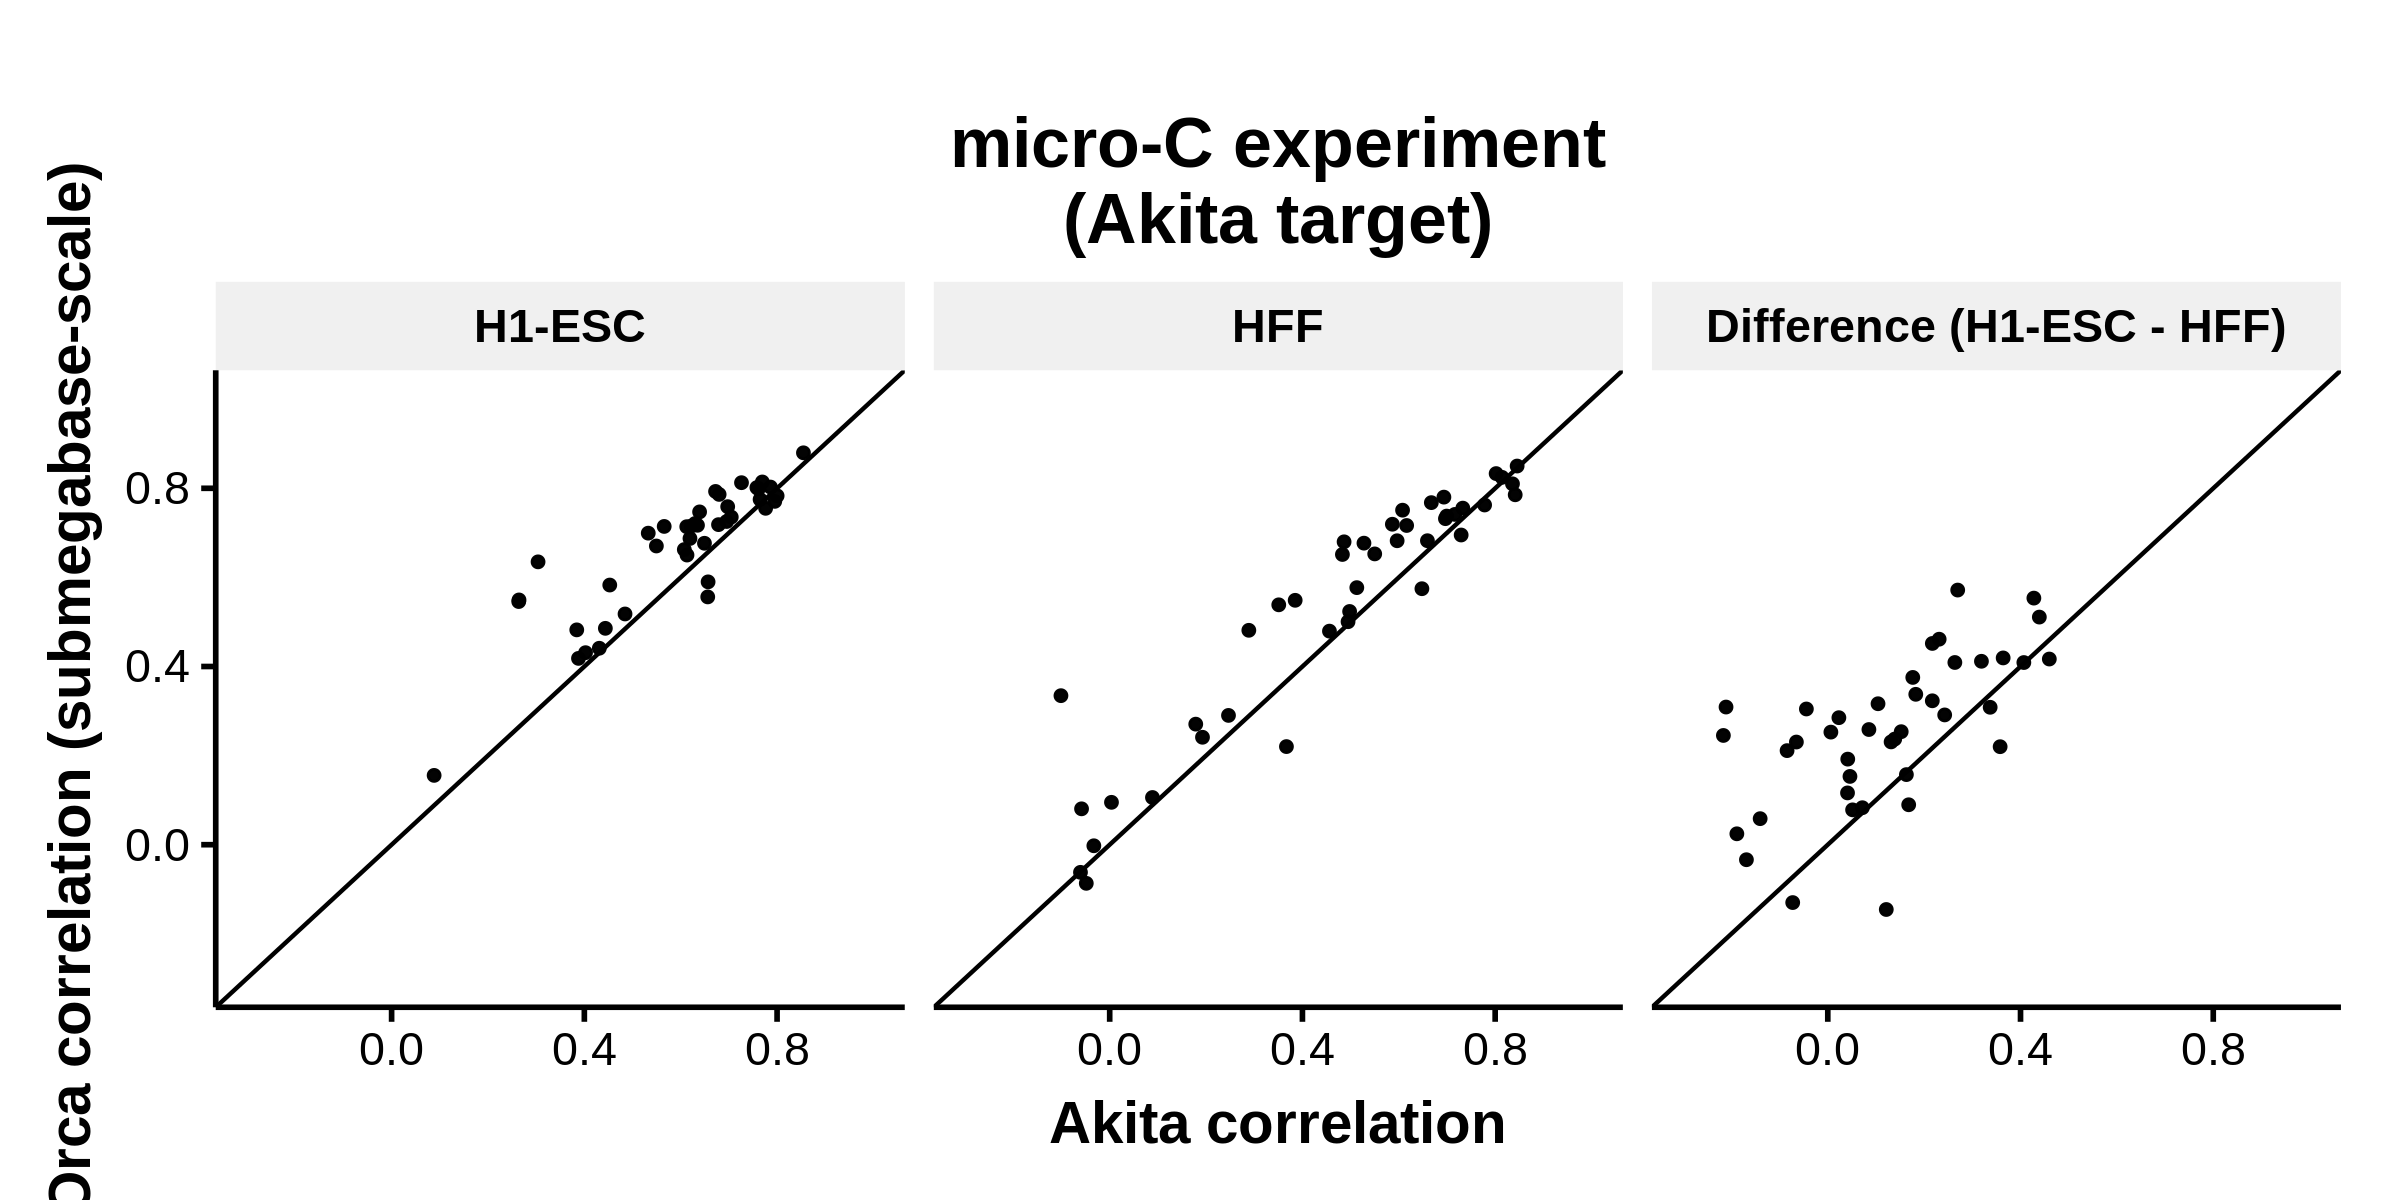

In [20]:
%%R -i plotdata -w 8 -h 4 --units in -r 300

require(data.table)
require(ggplot2)
require(patchwork)
theme_Publication <- function(base_size=14, base_family="helvetica") {
      library(grid)
      library(ggthemes)
      (theme_foundation(base_size=base_size, base_family=base_family)
       + theme(plot.title = element_text(face = "bold",
                                         size = rel(1.2), hjust = 0.5),
               text = element_text(),
               panel.background = element_rect(colour = NA),
               plot.background = element_rect(colour = NA),
               panel.border = element_rect(colour = NA),
               axis.title = element_text(face = "bold",size = rel(1)),
               axis.title.y = element_text(angle=90,vjust =2),
               axis.title.x = element_text(vjust = -0.2),
               axis.text = element_text(), 
               axis.line = element_line(colour="black"),
               axis.ticks = element_line(),
               panel.grid.major = element_blank(),
               panel.grid.minor = element_blank(),
               legend.key = element_rect(colour = NA),
               legend.position = "bottom",
               legend.direction = "horizontal",
               legend.key.size= unit(0.2, "cm"),
               legend.margin = unit(0, "cm"),
               legend.title = element_text(face="italic"),
               plot.margin=unit(c(10,5,5,5),"mm"),
               strip.background=element_rect(colour="#f0f0f0",fill="#f0f0f0"),
               strip.text = element_text(face="bold")
          ))
      
}

plotdata = data.table(plotdata)
print(plotdata[, .(akita_correlation=mean(akita)), by=celltype])
print(plotdata[, .(orca_correlation=mean(orca)), by=celltype])


plotdata$celltype = factor(plotdata$celltype, levels=c('H1-ESC','HFF','Difference (H1-ESC - HFF)'))
p= ggplot(plotdata)+geom_abline(slope=1)+geom_point(aes(y=orca, x=akita),size=I(1),alpha=I(0.99)) + facet_wrap(~celltype) + theme_minimal()+
scale_x_continuous(lim=c(-0.3,1))+scale_y_continuous(lim=c(-0.3,1))+xlab("Akita correlation")+
    ylab("Orca correlation (submegabase-scale)")+theme_Publication ()+labs(title = "micro-C experiment\n(Akita target)")

ggsave('./figures/akitacomparison.cor.akitatarget.pdf', device=cairo_pdf)
p

#uncomment to show comparison of ablated Orca models (1Mb model and 1Mb model without auxiliary task during training) with Akita
#print(plotdata[, .(orca_correlation=mean(orca_1m)), by=celltype])
#print(plotdata[, .(orca_correlation=mean(orca_no1d)), by=celltype])
#p2 = ggplot(plotdata)+geom_abline(slope=1)+geom_point(aes(y=orca_1m, x=akita),size=I(1),alpha=I(0.99)) + facet_wrap(~celltype) + theme_minimal()+
#scale_x_continuous(lim=c(-0.3,1))+scale_y_continuous(lim=c(-0.3,1))+xlab("Akita correlation")+
#    ylab("Orca correlation (submegabase-scale)")+theme_Publication ()+labs(title = "micro-C experiment\n(Akita target)", subtitle="Orca-1Mb model vs Akita")
#p3 = ggplot(plotdata)+geom_abline(slope=1)+geom_point(aes(y=orca_no1d, x=akita),size=I(1),alpha=I(0.99)) + facet_wrap(~celltype) + theme_minimal()+
#scale_x_continuous(lim=c(-0.3,1))+scale_y_continuous(lim=c(-0.3,1))+xlab("Akita correlation")+
#    ylab("Orca correlation (submegabase-scale)")+theme_Publication ()+labs(title = "micro-C experiment\n(Akita target)", subtitle="Orca-1Mb model without auxiliary task vs Akita")
#p2/p3

In [21]:
#average target - distance normalized

from scipy.stats import spearmanr, pearsonr
akita_cors  = []
orca_cors = []
for i in range(pakita.shape[1]):

    #because distance-based expectation normalization is implementedly slightly differently between the Akita and Orca
    #to allow comparison, we averaged the targets between the two 
    target = to_akita_format(ts_h1esc[i]) * 0.5 +  takita[0,i,:,:] * 0.5
    valid = (~np.isnan(pakita[0,i,:,:].flatten())) & (~np.isnan(target.flatten()))
    

    akita_cors.append(pearsonr(rm_diagmean(pakita[0,i,:,:]).flatten()[valid], rm_diagmean(target).flatten()[valid])[0])
    orca_cors.append(pearsonr(rm_diagmean(to_akita_format(ps_h1esc[i])).flatten()[valid], rm_diagmean(target).flatten()[valid])[0])

plotdata = pd.DataFrame(dict(akita=akita_cors,
                             orca=orca_cors, 
                             celltype='H1-ESC'))
akita_cors  = []
orca_cors = []
for i in range(pakita.shape[1]):
    target =  to_akita_format(ts_hff[i]) * 0.5 +  takita[1,i,:,:] * 0.5
    valid = (~np.isnan(pakita[1,i,:,:].flatten())) & (~np.isnan(target.flatten()))
    
    akita_cors.append(pearsonr(rm_diagmean(pakita[1,i,:,:]).flatten()[valid], rm_diagmean(target).flatten()[valid])[0])
    orca_cors.append(pearsonr(rm_diagmean(to_akita_format(ps_hff[i])).flatten()[valid], rm_diagmean(target).flatten()[valid])[0])

plotdata = pd.concat([plotdata, pd.DataFrame(dict(akita=akita_cors,
                             orca=orca_cors, 
                             celltype='HFF'))], axis=0)

akita_cors  = []
orca_cors = []
for i in range(pakita.shape[1]):
    target = to_akita_format(ts_h1esc[i]) * 0.5 - to_akita_format(ts_hff[i]) * 0.5 
    valid = (~np.isnan(pakita[0,i,:,:].flatten())) & (~np.isnan(target.flatten()))
    

    akita_cors.append(pearsonr(rm_diagmean(pakita[0,i,:,:]).flatten()[valid]-rm_diagmean(pakita[1,i,:,:]).flatten()[valid], rm_diagmean(target).flatten()[valid])[0])
    orca_cors.append(pearsonr(rm_diagmean(to_akita_format(ps_h1esc[i])).flatten()[valid]-rm_diagmean(to_akita_format(ps_hff[i])).flatten()[valid], rm_diagmean(target).flatten()[valid])[0])

plotdata = pd.concat([plotdata, pd.DataFrame(dict(akita=akita_cors,
                             orca=orca_cors, 
                             celltype='Difference (H1-ESC - HFF)'))], axis=0)

<PYTHONPATH>/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


                    celltype akita_correlation
1:                    H1-ESC         0.6463341
2:                       HFF         0.5038285
3: Difference (H1-ESC - HFF)         0.1326892
                    celltype orca_correlation
1:                    H1-ESC        0.7588894
2:                       HFF        0.6010674
3: Difference (H1-ESC - HFF)        0.3486793


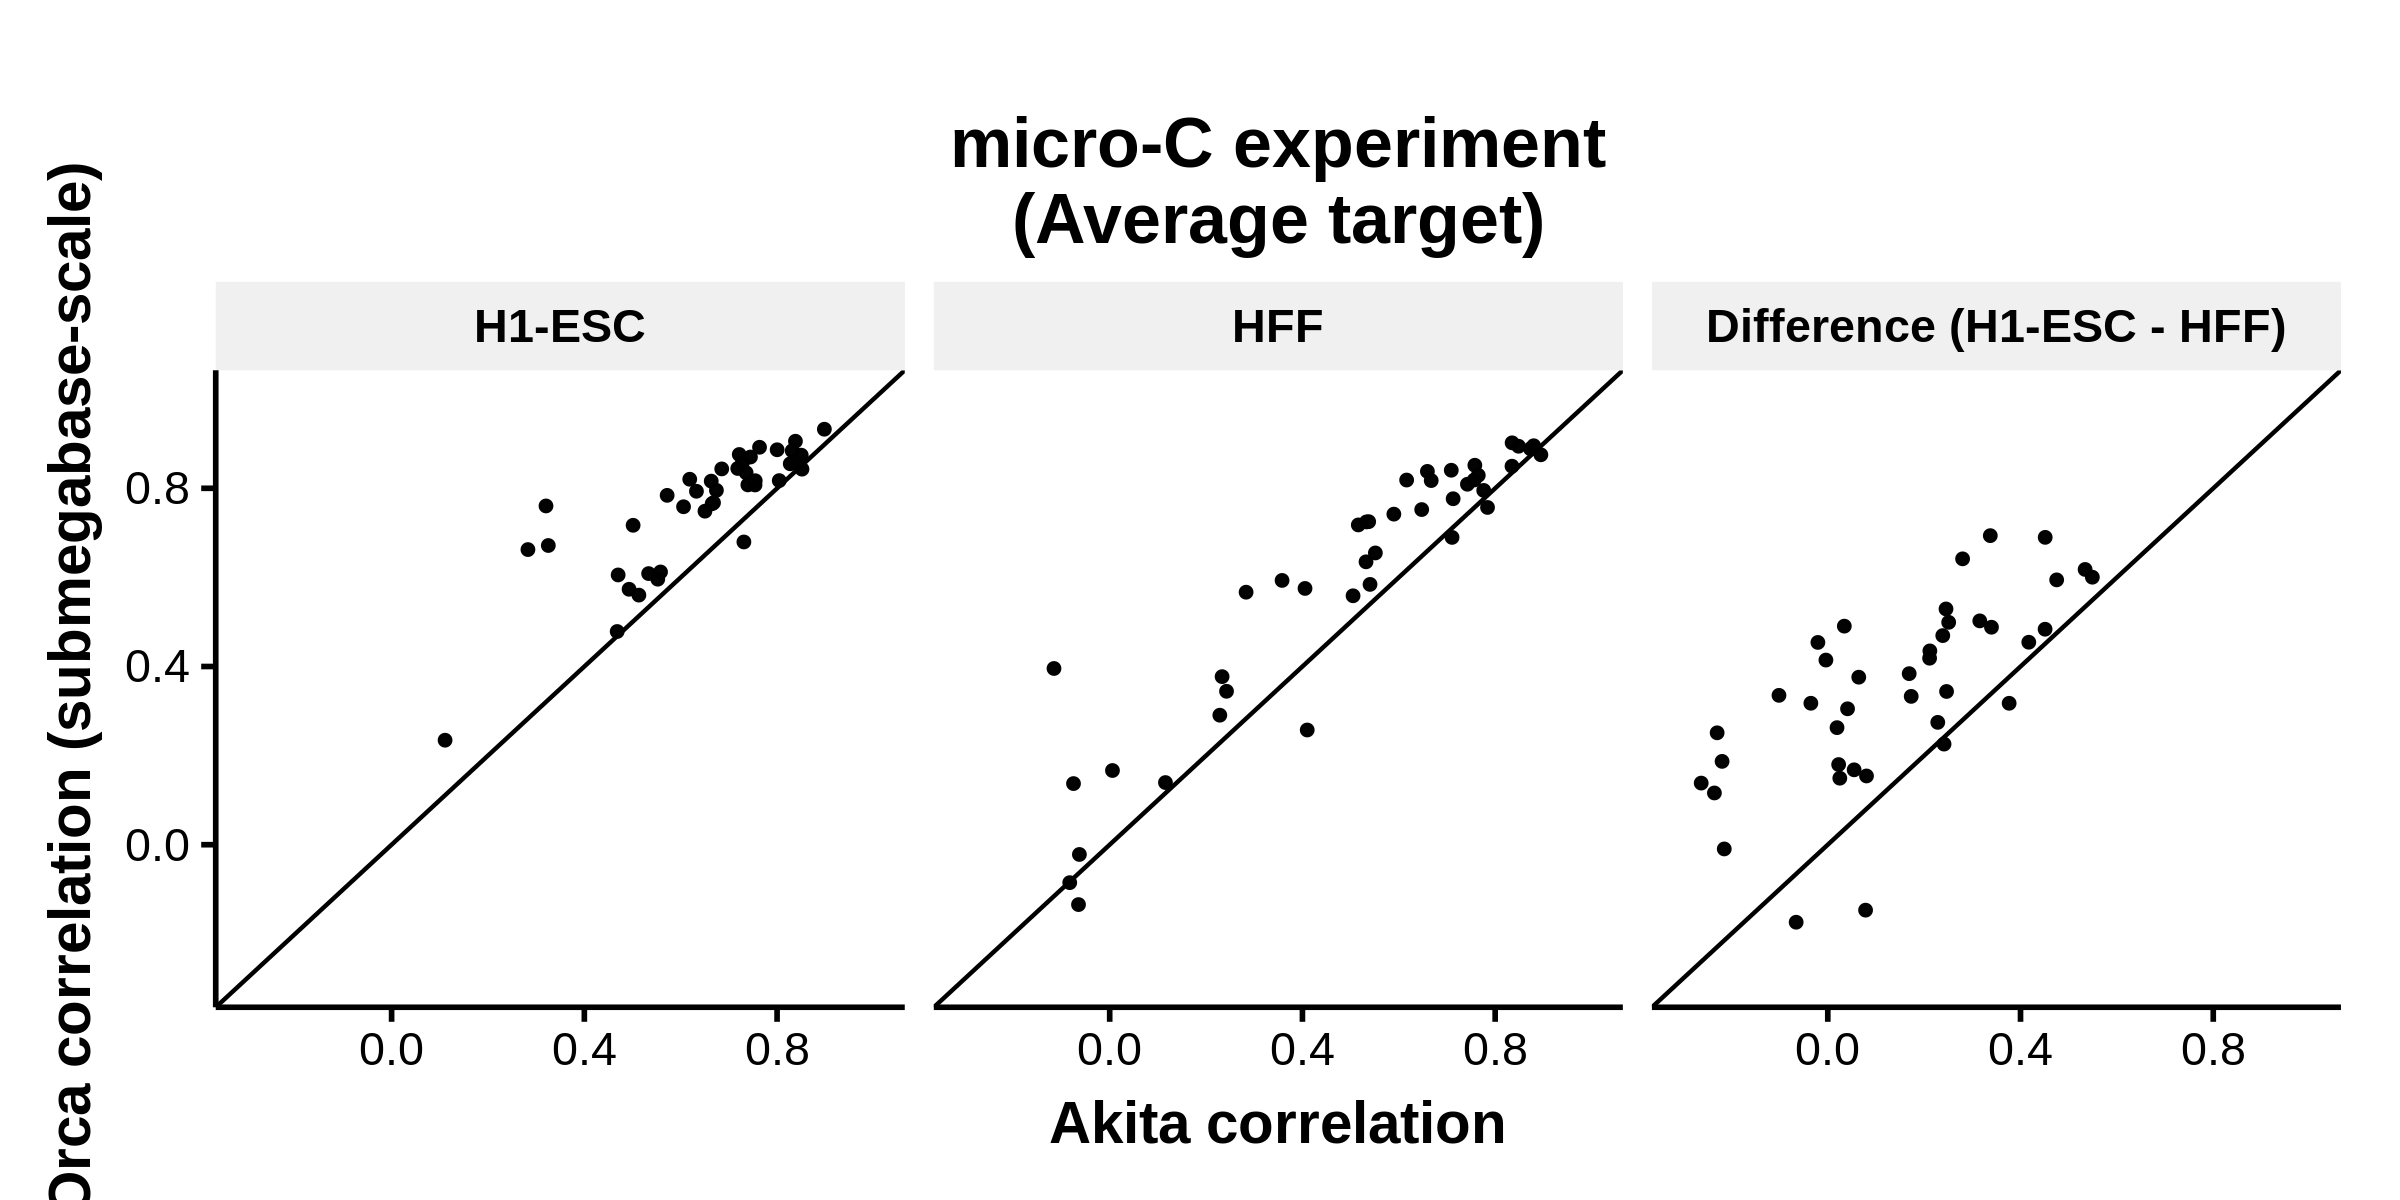

In [22]:
%%R -i plotdata -w 8 -h 4 --units in -r 300

require(data.table)
require(ggplot2)
theme_Publication <- function(base_size=14, base_family="helvetica") {
      library(grid)
      library(ggthemes)
      (theme_foundation(base_size=base_size, base_family=base_family)
       + theme(plot.title = element_text(face = "bold",
                                         size = rel(1.2), hjust = 0.5),
               text = element_text(),
               panel.background = element_rect(colour = NA),
               plot.background = element_rect(colour = NA),
               panel.border = element_rect(colour = NA),
               axis.title = element_text(face = "bold",size = rel(1)),
               axis.title.y = element_text(angle=90,vjust =2),
               axis.title.x = element_text(vjust = -0.2),
               axis.text = element_text(), 
               axis.line = element_line(colour="black"),
               axis.ticks = element_line(),
               panel.grid.major = element_blank(),
               panel.grid.minor = element_blank(),
               legend.key = element_rect(colour = NA),
               legend.position = "bottom",
               legend.direction = "horizontal",
               legend.key.size= unit(0.2, "cm"),
               legend.margin = unit(0, "cm"),
               legend.title = element_text(face="italic"),
               plot.margin=unit(c(10,5,5,5),"mm"),
               strip.background=element_rect(colour="#f0f0f0",fill="#f0f0f0"),
               strip.text = element_text(face="bold")
          ))
      
}

plotdata = data.table(plotdata)
print(plotdata[, .(akita_correlation=mean(akita)), by=celltype])
print(plotdata[, .(orca_correlation=mean(orca)), by=celltype])
plotdata$celltype = factor(plotdata$celltype, levels=c('H1-ESC','HFF','Difference (H1-ESC - HFF)'))
p= ggplot(plotdata)+geom_abline(slope=1)+geom_point(aes(y=orca, x=akita),size=I(1),alpha=I(0.99)) + facet_wrap(~celltype) + theme_minimal()+
scale_x_continuous(lim=c(-0.3,1))+scale_y_continuous(lim=c(-0.3,1))+xlab("Akita correlation")+
    ylab("Orca correlation (submegabase-scale)")+theme_Publication ()+labs(title = "micro-C experiment\n(Average target)")
p
ggsave('./figures/akitacomparison.cor.averagetarget.pdf', device=cairo_pdf)
p

In [23]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [24]:
takita_rmdiagmean = np.zeros_like(takita)
for i in range(2):
    for j in range(41):
        takita_rmdiagmean[i,j,:,:] = rm_diagmean(takita[i,j,:,:])
        
pakita_rmdiagmean = np.zeros_like(pakita)
for i in range(2):
    for j in range(41):
        pakita_rmdiagmean[i,j,:,:] = rm_diagmean(pakita[i,j,:,:])

porca_rmdiagmean = np.zeros_like(pakita)
for i in range(2):
    for j in range(41):
        if i == 0:
            porca_rmdiagmean[i,j,:,:] = rm_diagmean(to_akita_format(ps_h1esc[j]))
        else:
            porca_rmdiagmean[i,j,:,:] = rm_diagmean(to_akita_format(ps_hff[j]))


<PYTHONPATH>/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


In [25]:
#Genome interaction prediction performance for different region types 
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import roc_auc_score, average_precision_score
from collections import defaultdict
import numpy as np
import pandas as pd

mallbws = np.array(mallbws)
allbwthreshs = [ [np.percentile(mallbws[:,i,0,:].flatten(), 95) for i in range(10)] ]
allbwthresh90s = [ [np.percentile(mallbws[:,i,0,:].flatten(), 90) for i in range(10)]]

tthreshs = [[],[]]
for k in range(2):
    t = np.array([takita_rmdiagmean[k,i,:,:] for i in range(takita_rmdiagmean.shape[1])]).flatten()
    tthreshs[k].append(np.percentile(t[np.isfinite(t)],90))

levelsn = [1,2,4,8,16,32]

ts = ['CTCF','H3K4me3','H3K27ac', 'H3K4me1', 'H3K27me3']

target_cells = []
predict_cells = []
filter_features = []
aucs = []
aps = []
ap_baselines = []
Ns = []
levels = []
for target_cell in ['H1-ESC','HFF']:
    for t in range(5):
        p1s = defaultdict(list)
        p2s = defaultdict(list)
        t1s = defaultdict(list)
        t2s = defaultdict(list)

        for i in range(takita_rmdiagmean.shape[1]):
            for j in range(1):

                    p1 = pakita_rmdiagmean[0,i,:,:].flatten()
                    t1 = takita_rmdiagmean[0,i,:,:].flatten()
                    p2 = pakita_rmdiagmean[1,i,:,:].flatten()
                    t2 = takita_rmdiagmean[1,i,:,:].flatten()
                    
                    if target_cell == 'H1-ESC':
                        #CTCF-
                        b = ( (mallbws[i][0][j][:,None]<allbwthresh90s[j][0]) * (mallbws[i][0][j][None,:]<allbwthresh90s[j][0])).flatten()
                        #Target+
                        c = ( (mallbws[i][t][j][:,None]>allbwthreshs[j][t]) * (mallbws[i][t][j][None,:]>allbwthreshs[j][t])).flatten()
                        if t == 0:
                            filtered = ~c
                        else:
                            filtered = ~(b * c)
                    else:
                        b = ( (mallbws[i][0+5][j][:,None]<allbwthresh90s[j][0+5]) * (mallbws[i][0+5][j][None,:]<allbwthresh90s[j][0+5])).flatten()
                        c = ( (mallbws[i][t+5][j][:,None]>allbwthreshs[j][t+5]) * (mallbws[i][t+5][j][None,:]>allbwthreshs[j][t+5])).flatten()
                        if t == 0:
                            filtered = ~c
                        else:
                            filtered = ~(b * c)

                    valid = np.isfinite(t1) * np.isfinite(t2) * (~filtered) 
                    p1[~valid]=np.nan
                    t1[~valid]=np.nan

                    p1s[j].append(p1)
                    t1s[j].append(t1)

                    p2[~valid]=np.nan
                    t2[~valid]=np.nan
                    p2s[j].append(p2)
                    t2s[j].append(t2)
    
        if  target_cell == 'H1-ESC':
            tgts = t1s
        else:
            tgts = t2s
            
        for i in range(1):
            valid = np.isfinite(tgts[i])
            target_cells.append(target_cell)
            predict_cells.append('H1-ESC')
            filter_features.append(ts[t])
            Ns.append(np.sum(np.array(tgts[i])[valid]>tthreshs[0 if target_cell == 'H1-ESC' else 1][i]))
            levels.append(levelsn[i])
            if Ns[-1] > 20:
                aucs.append(roc_auc_score( np.array(tgts[i])[valid]>tthreshs[0 if target_cell == 'H1-ESC' else 1][i], np.array(p1s[i])[valid]))
                aps.append(average_precision_score( np.array(tgts[i])[valid]>tthreshs[0 if target_cell == 'H1-ESC' else 1][i], np.array(p1s[i])[valid]))
                ap_baselines.append(np.mean( np.array(tgts[i])[valid]>tthreshs[0 if target_cell == 'H1-ESC' else 1][i]))
            else:
                aucs.append(np.nan)
                aps.append(np.nan)
                ap_baselines.append(np.nan)

            target_cells.append(target_cell)
            predict_cells.append('HFF')
            filter_features.append(ts[t])
            Ns.append(np.sum(np.array(tgts[i])[valid]>tthreshs[0 if target_cell == 'H1-ESC' else 1][i]))
            levels.append(levelsn[i])
            if Ns[-1] > 20:
                aucs.append(roc_auc_score( np.array(tgts[i])[valid]>tthreshs[0 if target_cell == 'H1-ESC' else 1][i], np.array(p2s[i])[valid]))
                aps.append(average_precision_score( np.array(tgts[i])[valid]>tthreshs[0 if target_cell == 'H1-ESC' else 1][i], np.array(p2s[i])[valid]))
                ap_baselines.append(np.mean(np.array(tgts[i])[valid]>tthreshs[0 if target_cell == 'H1-ESC' else 1][i]))
            else:
                aucs.append(np.nan)
                aps.append(np.nan)
                ap_baselines.append(np.nan)

plotdata = pd.DataFrame(dict(auc=aucs, ap=aps, ap_baseline=ap_baselines, N=Ns, filter_feature=filter_features, target=target_cells, 
                             model=predict_cells, levels = levels))

In [26]:

levelsn = [1,2,4,8,16,32]

ts = ['CTCF','H3K4me3','H3K27ac', 'H3K4me1', 'H3K27me3']

target_cells = []
predict_cells = []
filter_features = []
aucs = []
aps = []
ap_baselines = []
Ns = []
levels = []
for target_cell in ['H1-ESC','HFF']:
    for t in range(5):
        p1s = defaultdict(list)
        p2s = defaultdict(list)
        t1s = defaultdict(list)
        t2s = defaultdict(list)

        for i in range(takita_rmdiagmean.shape[1]):
            for j in range(1):

                    p1 = porca_rmdiagmean[0,i,:,:].flatten()
                    t1 = takita_rmdiagmean[0,i,:,:].flatten()
                    p2 = porca_rmdiagmean[1,i,:,:].flatten()
                    t2 = takita_rmdiagmean[1,i,:,:].flatten()
                    
                    if target_cell == 'H1-ESC':
                        #CTCF-
                        b = ( (mallbws[i][0][j][:,None]<allbwthresh90s[j][0]) * (mallbws[i][0][j][None,:]<allbwthresh90s[j][0])).flatten()
                        #Target+
                        c = ( (mallbws[i][t][j][:,None]>allbwthreshs[j][t]) * (mallbws[i][t][j][None,:]>allbwthreshs[j][t])).flatten()
                        if t == 0:
                            filtered = ~c
                        else:
                            filtered = ~(b * c)
                    else:
                        b = ( (mallbws[i][0+5][j][:,None]<allbwthresh90s[j][0+5]) * (mallbws[i][0+5][j][None,:]<allbwthresh90s[j][0+5])).flatten()
                        c = ( (mallbws[i][t+5][j][:,None]>allbwthreshs[j][t+5]) * (mallbws[i][t+5][j][None,:]>allbwthreshs[j][t+5])).flatten()
                        if t == 0:
                            filtered = ~c
                        else:
                            filtered = ~(b * c)

                    valid = np.isfinite(t1) * np.isfinite(t2) * (~filtered) 
                    p1[~valid]=np.nan
                    t1[~valid]=np.nan

                    p1s[j].append(p1)
                    t1s[j].append(t1)

                    p2[~valid]=np.nan
                    t2[~valid]=np.nan
                    p2s[j].append(p2)
                    t2s[j].append(t2)
    
        if  target_cell == 'H1-ESC':
            tgts = t1s
        else:
            tgts = t2s
            
        for i in range(1):
            valid = np.isfinite(tgts[i])
            target_cells.append(target_cell)
            predict_cells.append('H1-ESC')
            filter_features.append(ts[t])
            Ns.append(np.sum(np.array(tgts[i])[valid]>tthreshs[0 if target_cell == 'H1-ESC' else 1][i]))
            levels.append(levelsn[i])
            if Ns[-1] > 20:
                aucs.append(roc_auc_score( np.array(tgts[i])[valid]>tthreshs[0 if target_cell == 'H1-ESC' else 1][i], np.array(p1s[i])[valid]))
                aps.append(average_precision_score( np.array(tgts[i])[valid]>tthreshs[0 if target_cell == 'H1-ESC' else 1][i], np.array(p1s[i])[valid]))
                ap_baselines.append(np.mean( np.array(tgts[i])[valid]>tthreshs[0 if target_cell == 'H1-ESC' else 1][i]))
            else:
                aucs.append(np.nan)
                aps.append(np.nan)
                ap_baselines.append(np.nan)

            target_cells.append(target_cell)
            predict_cells.append('HFF')
            filter_features.append(ts[t])
            Ns.append(np.sum(np.array(tgts[i])[valid]>tthreshs[0 if target_cell == 'H1-ESC' else 1][i]))
            levels.append(levelsn[i])
            if Ns[-1] > 20:
                aucs.append(roc_auc_score( np.array(tgts[i])[valid]>tthreshs[0 if target_cell == 'H1-ESC' else 1][i], np.array(p2s[i])[valid]))
                aps.append(average_precision_score( np.array(tgts[i])[valid]>tthreshs[0 if target_cell == 'H1-ESC' else 1][i], np.array(p2s[i])[valid]))
                ap_baselines.append(np.mean(np.array(tgts[i])[valid]>tthreshs[0 if target_cell == 'H1-ESC' else 1][i]))
            else:
                aucs.append(np.nan)
                aps.append(np.nan)
                ap_baselines.append(np.nan)

plotdata2 = pd.DataFrame(dict(auc=aucs, ap=aps, ap_baseline=ap_baselines, N=Ns, filter_feature=filter_features, target=target_cells, 
                             model=predict_cells, levels = levels))

In [27]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


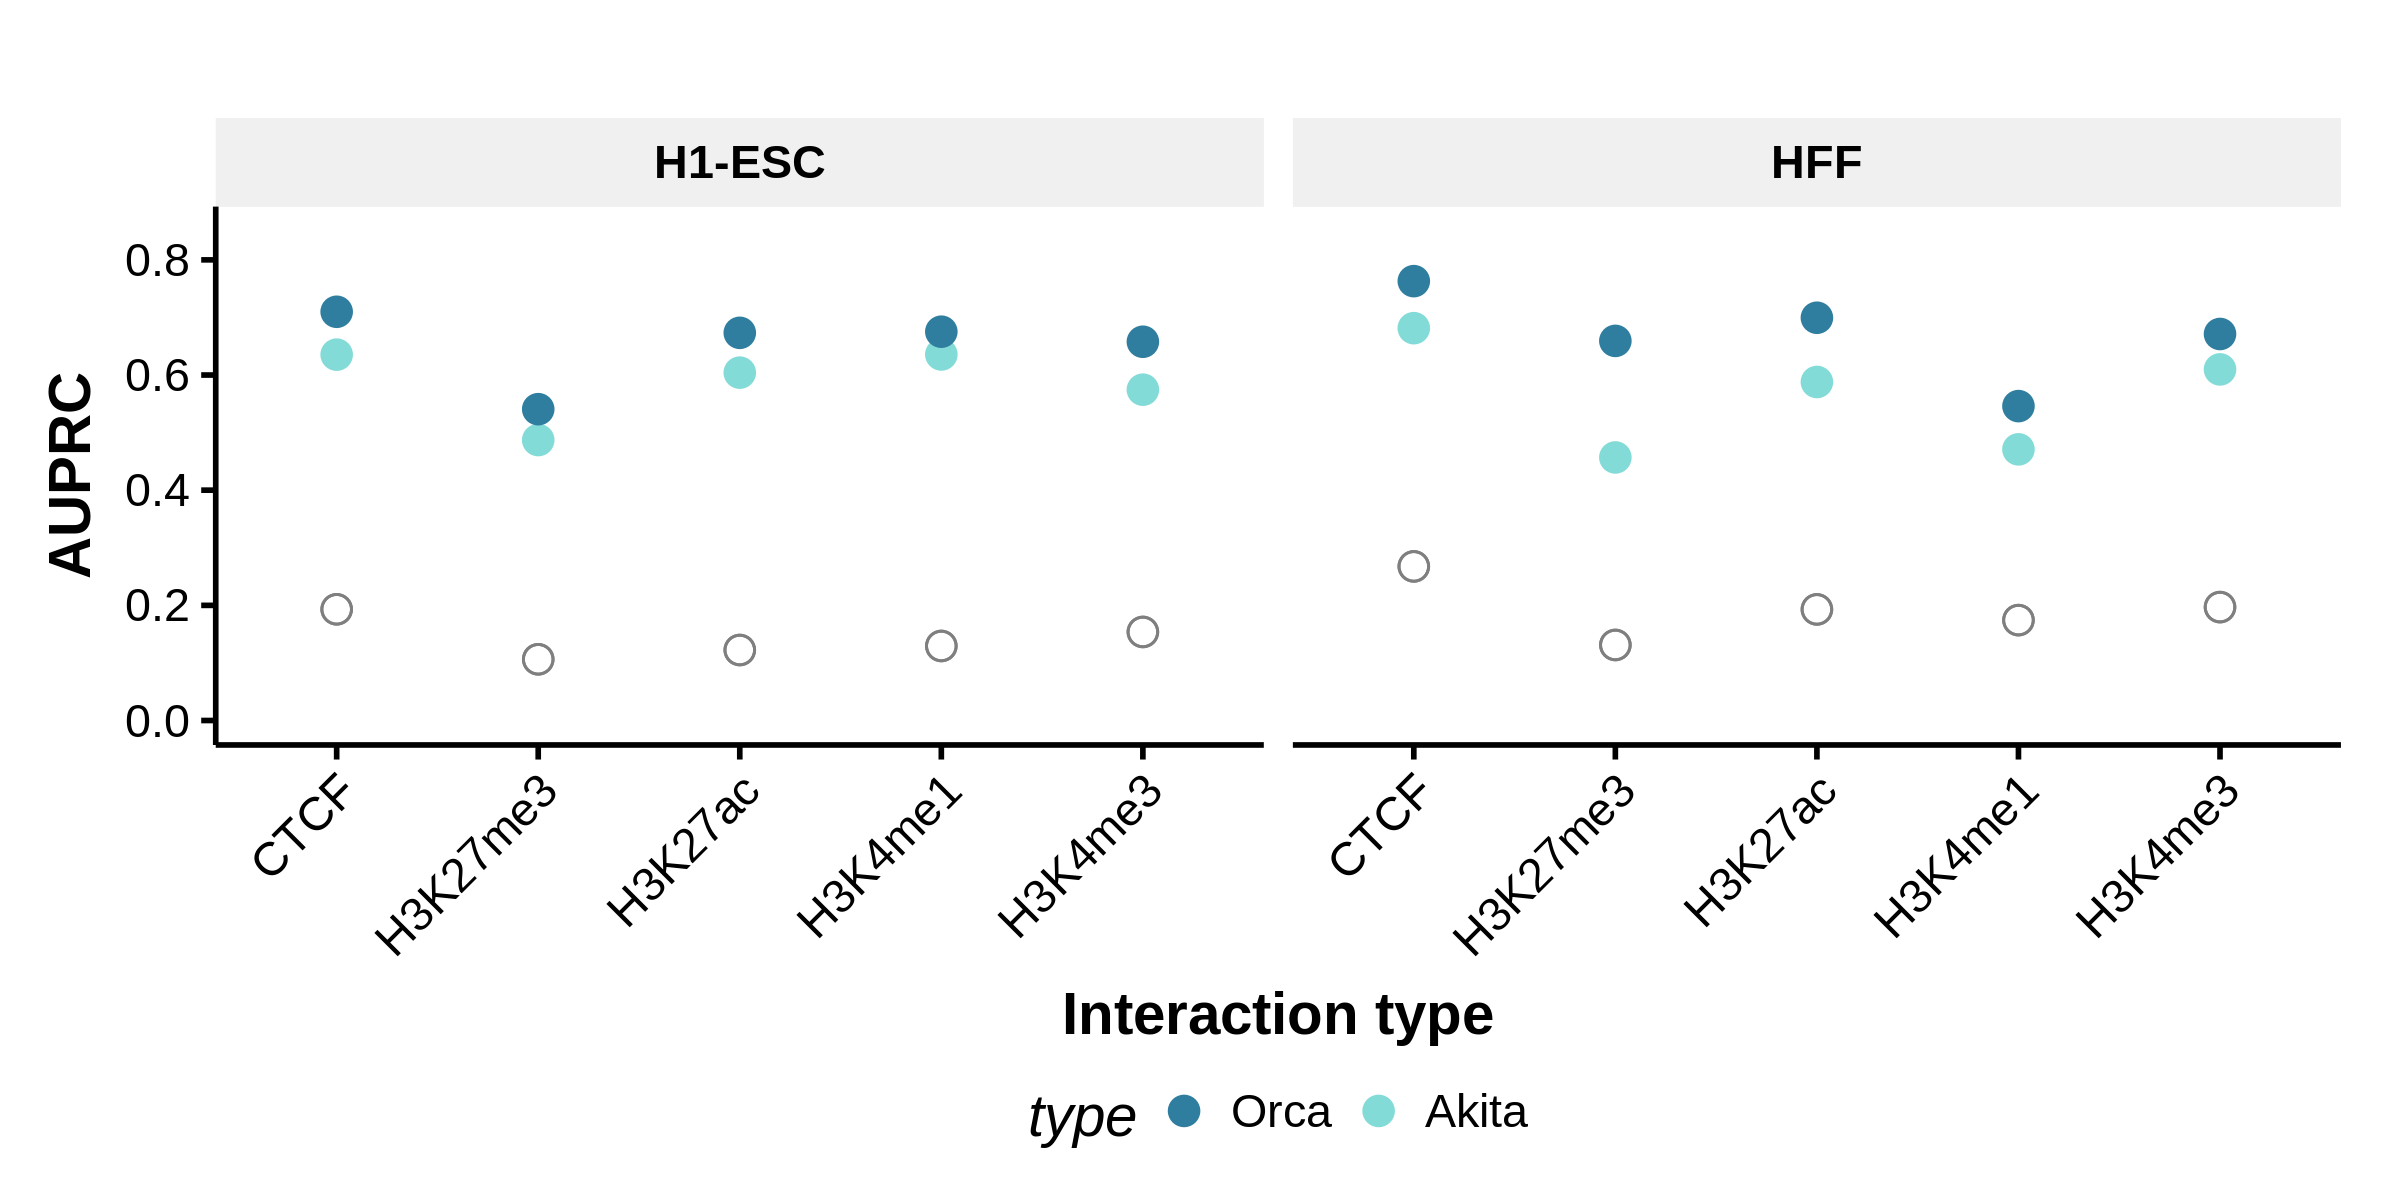

In [28]:
%%R -i plotdata,plotdata2 -w 8 -h 4 --units in -r 300
#Plot genome interaction prediction performance for different region types 
library(ggrastr)
require(ggplot2)
require(data.table)
theme_Publication <- function(base_size=14, base_family="helvetica") {
      library(grid)
      library(ggthemes)
      (theme_foundation(base_size=base_size, base_family=base_family)
       + theme(plot.title = element_text(face = "bold",
                                         size = rel(1.2), hjust = 0.5),
               text = element_text(),
               panel.background = element_rect(colour = NA),
               plot.background = element_rect(colour = NA),
               panel.border = element_rect(colour = NA),
               axis.title = element_text(face = "bold",size = rel(1)),
               axis.title.y = element_text(angle=90,vjust =2),
               axis.title.x = element_text(vjust = -0.2),
               axis.text = element_text(), 
               axis.line = element_line(colour="black"),
               axis.ticks = element_line(),
               panel.grid.major = element_blank(),
               panel.grid.minor = element_blank(),
               legend.key = element_rect(colour = NA),
               legend.position = "bottom",
               legend.direction = "horizontal",
               legend.key.size= unit(0.2, "cm"),
               legend.margin = unit(0, "cm"),
               legend.title = element_text(face="italic"),
               plot.margin=unit(c(10,5,5,5),"mm"),
               strip.background=element_rect(colour="#f0f0f0",fill="#f0f0f0"),
               strip.text = element_text(face="bold")
          ))
      
}

plotdata = data.table(plotdata)
plotdata$filter_feature = factor(plotdata$filter_feature, levels=c('CTCF', 'H3K27me3','H3K27ac',  'H3K4me1', 'H3K4me3'))
plotdata$type = 'Akita'

plotdata2 = data.table(plotdata2)
plotdata2$filter_feature = factor(plotdata2$filter_feature, levels=c('CTCF', 'H3K27me3','H3K27ac',  'H3K4me1', 'H3K4me3'))
plotdata2$type = 'Orca'

plotdata = rbind(plotdata, plotdata2)
plotdata$type=factor(plotdata$type, levels=c('Orca','Akita'))
p = ggplot(plotdata[levels==1 & target == model,]) + geom_point(aes(x=factor(filter_feature),y=ap,color=type),size=I(3),stat='identity',position='dodge')+
    geom_point(aes(x=factor(filter_feature),y=ap_baseline),color='gray50',shape=21, size=I(3),stat='identity',position='dodge')+
    facet_grid(~target)+theme_Publication()+xlab('Interaction type')+ylab('AUPRC')+theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))+
    scale_color_manual(values=c('#307E9F','#83DBD7'))+coord_cartesian(ylim=c(0,0.85))

ggsave('./figures/akitacomparison.perf.types.ap.pdf', device=cairo_pdf)
p

In [29]:
plotdata[plotdata['target']==plotdata['model']]

,auc,ap,ap_baseline,N,filter_feature,target,model,levels
0,0.865991,0.635384,0.193142,8224,CTCF,H1-ESC,H1-ESC,1
2,0.865321,0.574558,0.153793,1338,H3K4me3,H1-ESC,H1-ESC,1
4,0.882494,0.604132,0.122438,2294,H3K27ac,H1-ESC,H1-ESC,1
6,0.891837,0.635684,0.129457,1416,H3K4me1,H1-ESC,H1-ESC,1
8,0.832907,0.487062,0.106319,1918,H3K27me3,H1-ESC,H1-ESC,1
11,0.849674,0.681385,0.267654,8134,CTCF,HFF,HFF,1
13,0.865482,0.609751,0.196973,1640,H3K4me3,HFF,HFF,1
15,0.855794,0.587900,0.192978,3210,H3K27ac,HFF,HFF,1
17,0.804032,0.470913,0.174359,2448,H3K4me1,HFF,HFF,1
19,0.853493,0.456853,0.131201,7712,H3K27me3,HFF,HFF,1


In [30]:
plotdata2[plotdata['target']==plotdata['model']]

,auc,ap,ap_baseline,N,filter_feature,target,model,levels
0,0.895696,0.709834,0.193142,8224,CTCF,H1-ESC,H1-ESC,1
2,0.889597,0.657780,0.153793,1338,H3K4me3,H1-ESC,H1-ESC,1
4,0.911188,0.673272,0.122438,2294,H3K27ac,H1-ESC,H1-ESC,1
6,0.901843,0.675242,0.129457,1416,H3K4me1,H1-ESC,H1-ESC,1
8,0.865622,0.540687,0.106319,1918,H3K27me3,H1-ESC,H1-ESC,1
11,0.872722,0.763044,0.267654,8134,CTCF,HFF,HFF,1
13,0.863379,0.671277,0.196973,1640,H3K4me3,HFF,HFF,1
15,0.877037,0.699471,0.192978,3210,H3K27ac,HFF,HFF,1
17,0.829879,0.546026,0.174359,2448,H3K4me1,HFF,HFF,1
19,0.880752,0.659280,0.131201,7712,H3K27me3,HFF,HFF,1
